In [151]:
import math
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, nn, ops, random, vmap
from jax.scipy.special import logit, expit

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary, hpdi
from numpyro.infer import ELBO, MCMC, NUTS, SVI, Predictive, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

In [31]:
eagles = pd.read_csv("../data/eagles.csv", sep=";")
d = eagles
d.drop(columns="Unnamed: 0", inplace=True)
d["P_cat"] = d.P.apply(lambda x: {'S': 0, 'L': 1}[x])
d["A_cat"] = d.A.apply(lambda x: {'I': 0, 'A': 1}[x])
d["V_cat"] = d.V.apply(lambda x: {'S': 0, 'L': 1}[x])
d

,y,n,P,A,V,P_cat,A_cat,V_cat
0,17,24,L,A,L,1,1,1
1,29,29,L,A,S,1,1,0
2,17,27,L,I,L,1,0,1
3,20,20,L,I,S,1,0,0
4,1,12,S,A,L,0,1,1
5,15,16,S,A,S,0,1,0
6,0,28,S,I,L,0,0,1
7,1,4,S,I,S,0,0,0



## eagles {MASS}	R Documentation
### Foraging Ecology of Bald Eagles
#### Description

Knight and Skagen collected during a field study on the foraging behaviour of wintering Bald Eagles in Washington State, USA data concerning 160 attempts by one (pirating) Bald Eagle to steal a chum salmon from another (feeding) Bald Eagle.

#### Usage
eagles

#### Format
The eagles data frame has 8 rows and 5 columns.

y - Number of successful attempts.

n - Total number of attempts.

P - Size of pirating eagle (L = large, S = small).

A - Age of pirating eagle (I = immature, A = adult).

V - Size of victim eagle (L = large, S = small).

#### Source
Knight, R. L. and Skagen, S. K. (1988) Agonistic asymmetries and the foraging ecology of Bald Eagles. Ecology 69, 1188–1194.

References
Venables, W. N. and Ripley, B. D. (1999) Modern Applied Statistics with S-PLUS. Third Edition. Springer.

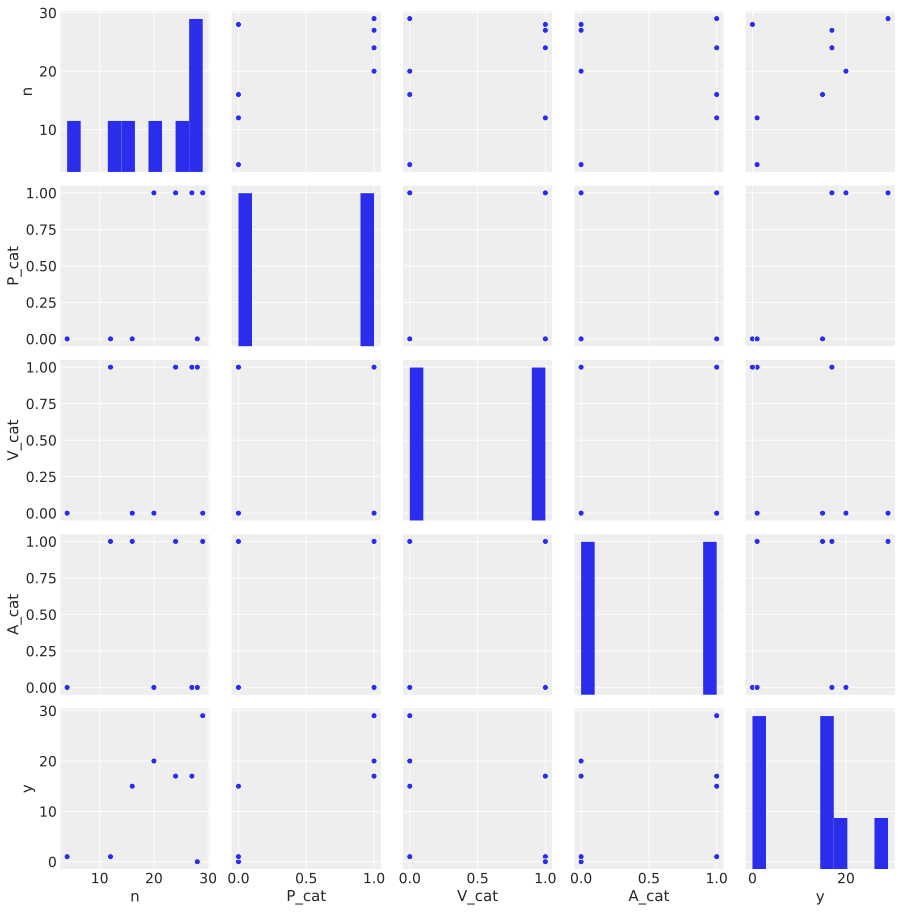

In [34]:
import seaborn as sns
sns.pairplot(d[["n", "P_cat", "V_cat", "A_cat", "y"]])

In [62]:
def model(n=None, P_cat=None, A_cat=None, V_cat=None, y=None):
    a = numpyro.sample('a', dist.Normal(0, 1.5))

    bP = numpyro.sample('bP', dist.Normal(0, 0.5))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    bV = numpyro.sample('bV', dist.Normal(0, 0.5))

    logit_p = a + bP * P_cat + bA * A_cat + bV * V_cat
    numpyro.deterministic("p", expit(logit_p))

    numpyro.sample('y', dist.Binomial(n, logits=logit_p), obs=y)

In [153]:
data = {col: d[col].values for col in ['n', 'P_cat', 'A_cat', 'V_cat', 'y']}
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples = mcmc.get_samples()
logprob = log_likelihood(model, post_samples2, **data)
az1 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:08<00:00, 185.22it/s, 7 steps of size 4.25e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.30      0.39      0.32     -0.41      0.86    391.11      1.00
        bA      0.67      0.31      0.66      0.16      1.18    681.90      1.00
        bP      1.62      0.31      1.60      1.06      2.08    593.07      1.00
        bV     -1.68      0.32     -1.68     -2.21     -1.15    448.35      1.00

Number of divergences: 0


In [117]:
quap = AutoLaplaceApproximation(model)
svi = SVI(model, quap, optim.Adam(1), ELBO(), **data)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p_quap = svi.get_params(state)
post_quap = quap.sample_posterior(random.PRNGKey(1), p_quap, (1000,))
print_summary(post_quap, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.29      0.36      0.27     -0.29      0.82   1049.96      1.00
        bA      0.66      0.31      0.67      0.20      1.18    890.16      1.00
        bP      1.62      0.31      1.63      1.17      2.15   1088.12      1.00
        bV     -1.68      0.32     -1.67     -2.27     -1.27   1115.73      1.00
      p[0]      0.71      0.06      0.71      0.61      0.81    984.09      1.00
      p[1]      0.93      0.03      0.93      0.89      0.97    994.03      1.00
      p[2]      0.56      0.07      0.56      0.45      0.66    788.43      1.00
      p[3]      0.87      0.04      0.87      0.80      0.93    920.80      1.00
      p[4]      0.33      0.07      0.33      0.22      0.43   1010.80      1.00
      p[5]      0.72      0.07      0.72      0.61      0.83    921.38      1.00
      p[6]      0.20      0.05      0.20      0.13      0.28    967.28      1.00
      p[7]      0.57      0

<AxesSubplot:>

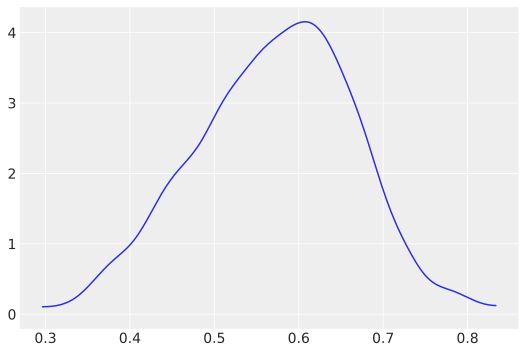

In [78]:
az.plot_kde(expit(post_samples['a']))

<AxesSubplot:>

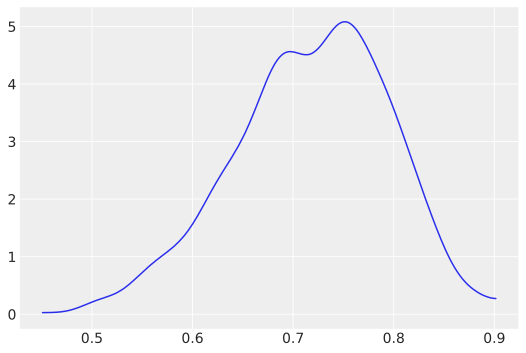

In [79]:
az.plot_kde(expit(post_samples['a'] + post_samples["bA"]))

<AxesSubplot:>

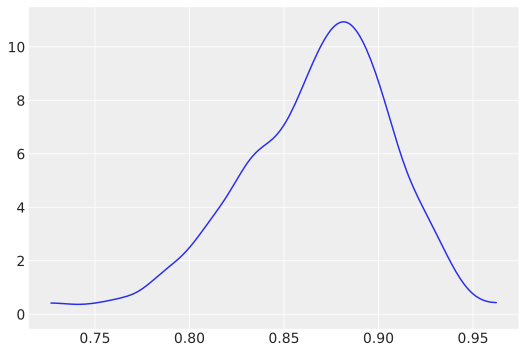

In [80]:
az.plot_kde(expit(post_samples['a'] + post_samples["bP"]))

<AxesSubplot:>

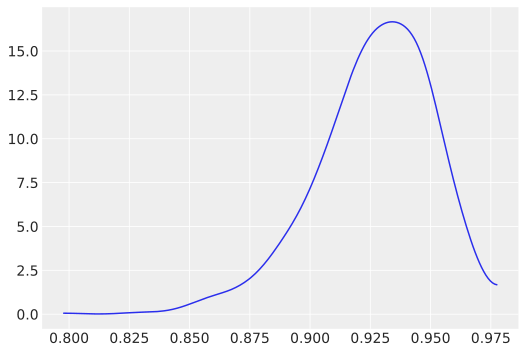

In [81]:
az.plot_kde(expit(post_samples['a'] + post_samples["bA"] + post_samples["bP"]))

<AxesSubplot:>

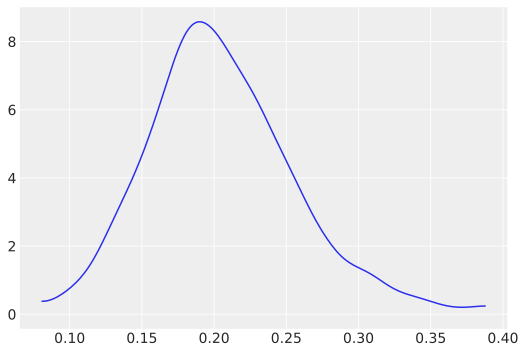

In [82]:
az.plot_kde(expit(post_samples['a'] + post_samples["bV"]))

In [136]:
post = Predictive(model, post_samples).get_samples(
    random.PRNGKey(3), **{col: d[col].values for col in ['n', 'P_cat', 'A_cat', 'V_cat']}
)
post_p = post["p"]
p_mean = jnp.mean(post_p, 0)
p_HPDI = hpdi(post_p, 0.89)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

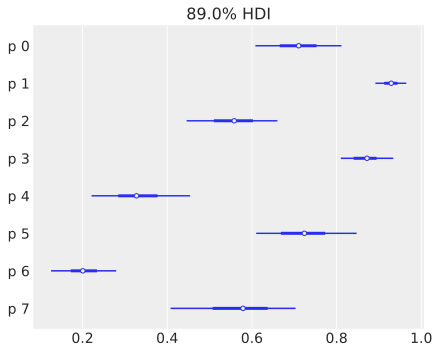

In [137]:
az.plot_forest({"p": post["p"][None, ...]}, hdi_prob=0.89)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

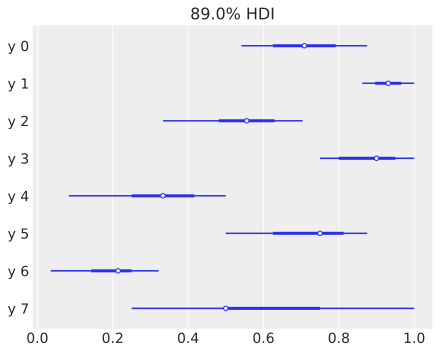

In [141]:
az.plot_forest({"y": post["y"][None, ...] / d.n.values}, hdi_prob=0.89)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

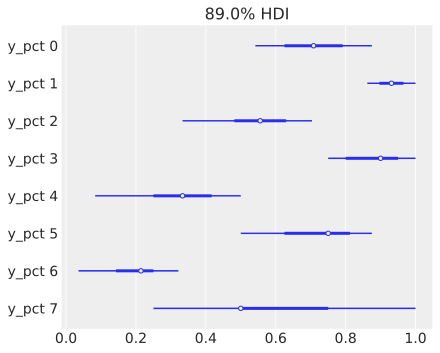

In [142]:
az.plot_forest({"y_pct": post["y"][None, ...] / d.n.values}, hdi_prob=0.89)

In [145]:
def model2(n=None, P_cat=None, A_cat=None, V_cat=None, y=None):
    a = numpyro.sample('a', dist.Normal(0, 1.5))

    bP = numpyro.sample('bP', dist.Normal(0, 0.5))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    bV = numpyro.sample('bV', dist.Normal(0, 0.5))
    bAP = numpyro.sample('bAP', dist.Normal(0, 0.5))

    logit_p = a + bP * P_cat + bA * A_cat + bV * V_cat + bAP * A_cat * P_cat
    numpyro.deterministic("p", expit(logit_p))

    numpyro.sample('y', dist.Binomial(n, logits=logit_p), obs=y)

In [154]:
data = {col: d[col].values for col in ['n', 'P_cat', 'A_cat', 'V_cat', 'y']}
mcmc = MCMC(NUTS(model2), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples2 = mcmc.get_samples()
logprob = log_likelihood(model2, post_samples2, **data)
az2 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:06<00:00, 247.99it/s, 15 steps of size 3.97e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.36      0.35      0.36     -0.26      0.89    525.72      1.00
        bA      0.57      0.33      0.56      0.06      1.13    741.39      1.00
       bAP      0.30      0.38      0.28     -0.30      0.93    781.47      1.00
        bP      1.56      0.32      1.56      1.06      2.09    680.64      1.01
        bV     -1.73      0.31     -1.74     -2.22     -1.24    684.08      1.00

Number of divergences: 0


In [155]:
az.compare({'az1': az1, 'az2': az2}, ic='waic', scale='deviance')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
az2,0,59.8568,8.69322,0,0.719688,10.1147,0,True,deviance
az1,1,62.0388,9.26765,2.18197,0.280312,10.5646,1.66655,True,deviance


In [166]:
# prob that first model has better waic
diff = numpyro.sample('d', dist.Normal(2.18, 1.66).expand([1000]), rng_key=random.PRNGKey(11))
jnp.mean(diff < 0)

DeviceArray(0.107, dtype=float32)

---
### 11h4

In [281]:
salamander = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/salamanders.csv", sep=";")
d = salamander
d.columns = d.columns.str.lower()
print(d.shape)
display(d.head())
d.describe()

(47, 4)


,site,salaman,pctcover,forestage
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43


,site,salaman,pctcover,forestage
count,47.000000,47.000000,47.000000,47.000000
mean,24.000000,2.468085,58.978723,168.808511
std,13.711309,3.374141,35.776777,193.513244
min,1.000000,0.000000,0.000000,0.000000
25%,12.500000,0.000000,18.000000,29.500000
50%,24.000000,1.000000,83.000000,64.000000
75%,35.500000,3.000000,88.000000,266.500000
max,47.000000,13.000000,93.000000,675.000000


In [282]:
d['pctcover_std'] = d["pctcover"] / 100
d['forestage_std'] = d.forestage / d.forestage.max()
d['log_forestage'] = jnp.log(1 + d.forestage.values)
d['log_forestage_ctr'] = d['log_forestage'] - d['log_forestage'].mean()

In [283]:
d.log_forestage_ctr.values

array([ 1.5780802 ,  0.30781507,  2.127277  , -0.00643396, -0.39663172,
        1.7299752 ,  1.1224833 ,  0.09584475, -0.41962123,  2.1327267 ,
        2.3353715 ,  1.2036738 ,  1.180471  ,  1.8081398 ,  1.6997118 ,
        1.990879  , -2.389062  , -0.7468343 ,  2.1327267 , -2.794527  ,
       -1.4082327 , -0.7150855 , -1.7829261 , -0.26879835, -0.7468343 ,
        1.194457  ,  2.1942034 ,  0.48261786,  1.1710367 , -4.1808214 ,
       -2.5713835 , -2.794527  , -3.082209  , -1.7829261 , -1.9835968 ,
       -2.2349112 , -0.26879835, -0.779624  , -0.12037849, -0.0864768 ,
        0.18862629, -0.24899578,  1.5906196 ,  1.8402019 ,  0.7170186 ,
       -0.06994772,  1.0556207 ], dtype=float32)

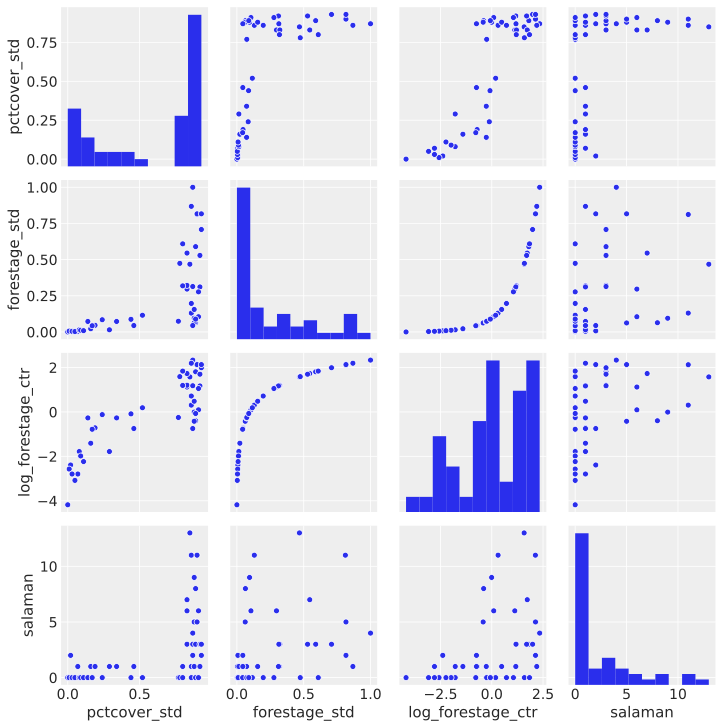

In [284]:
import seaborn as sns
sns.pairplot(d[["pctcover_std", "forestage_std", "log_forestage_ctr", "salaman"]])

In [285]:
def model(salaman=None, pctcover_std=None):
    a = numpyro.sample("a", dist.Normal(1.5, .25))
    bC = numpyro.sample("bC", dist.Normal(0, 0.5))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a + bC * pctcover_std))
    numpyro.sample("salaman", dist.Poisson(lambda_), obs=salaman)

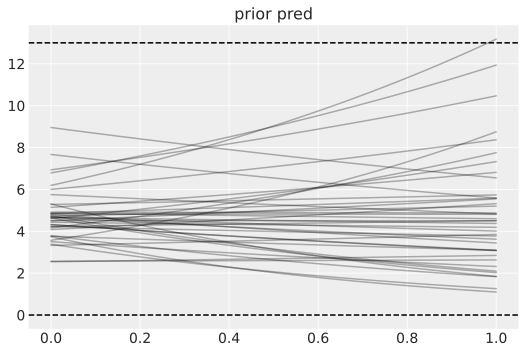

In [286]:
x = jnp.linspace(0, 1, 100)
lmu = Predictive(model, num_samples=100, return_sites=["lambda"]).get_samples(
    random.PRNGKey(53),
    pctcover_std=x,
)["lambda"]
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=d.salaman.max(), c="k", ls="--")#, lw=0.5)
plt.title("prior pred")

for i in range(40):
    plt.plot(x, lmu[i], "k", alpha=0.3)

In [287]:
data = {col: d[col].values for col in ['pctcover_std', 'salaman']}
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples1 = mcmc.get_samples()
logprob = log_likelihood(model, post_samples1, **data)
az1 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:04<00:00, 319.92it/s, 7 steps of size 4.29e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.44      0.15      0.44      0.21      0.71    256.70      1.00
        bC      0.92      0.21      0.93      0.56      1.25    245.52      1.00

Number of divergences: 0


<AxesSubplot:>

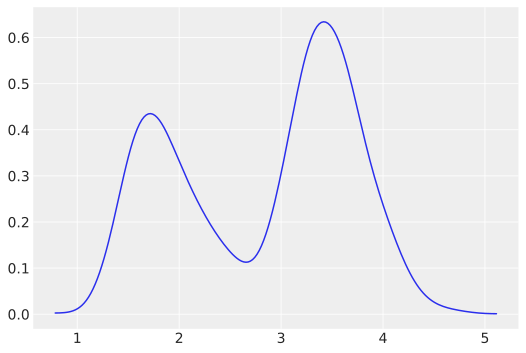

In [288]:
az.plot_kde(post_samples1["lambda"])

<AxesSubplot:>

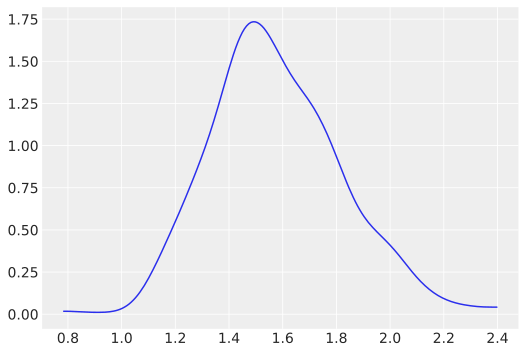

In [289]:
az.plot_kde(jnp.exp(post_samples1["a"]))

<AxesSubplot:>

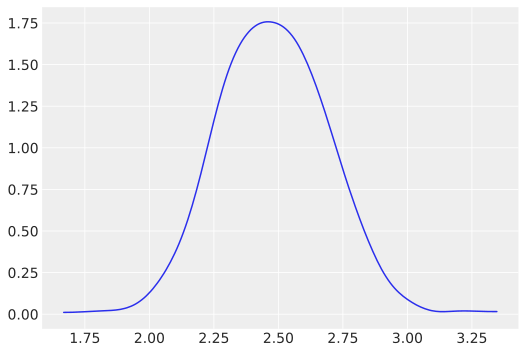

In [290]:
az.plot_kde(jnp.exp(post_samples1["a"] + post_samples1["bC"] * 0.5))

<AxesSubplot:>

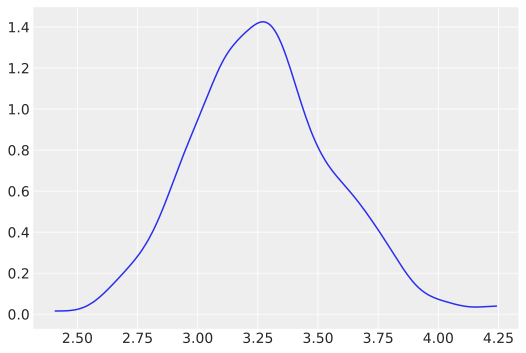

In [291]:
az.plot_kde(jnp.exp(post_samples1["a"] + post_samples1["bC"] * 0.8))

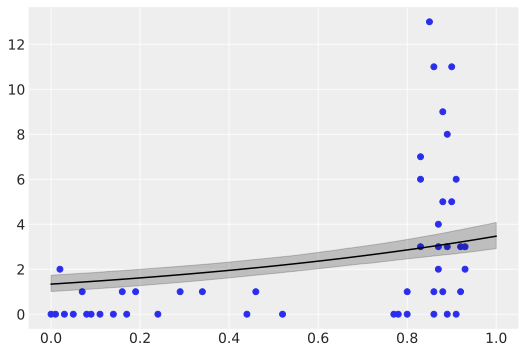

In [292]:
x = jnp.linspace(0, 1, 100)

lambda_ = Predictive(model, post_samples1, return_sites=["lambda"]).get_samples(
    random.PRNGKey(3), pctcover_std=x)["lambda"]
lmu = jnp.mean(post_pred, axis=0)
lci = jnp.percentile(post_pred, q=(5.5, 94.5), axis=0)

plt.scatter(d.pctcover_std.values, d.salaman.values)
plt.plot(x, lmu, 'k')
plt.fill_between(x, lci[0], lci[1], color="k", alpha=0.2)

In [293]:
def model2(salaman=None, pctcover_std=None, forestage_std=None):
    a = numpyro.sample("a", dist.Normal(1.5, .25))
    bC = numpyro.sample("bC", dist.Normal(0, 0.5))
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a + bC * pctcover_std) + bF * forestage_std)
    numpyro.sample("salaman", dist.Poisson(lambda_), obs=salaman)

In [294]:
data = {col: d[col].values for col in ['pctcover_std', 'forestage_std', 'salaman']}
mcmc = MCMC(NUTS(model2), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()
post_samples2 = mcmc.get_samples()
logprob = log_likelihood(model2, post_samples2, **data)
az2 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:04<00:00, 300.36it/s, 7 steps of size 4.34e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.44      0.15      0.44      0.21      0.68    373.61      1.00
        bC      0.91      0.22      0.90      0.56      1.25    367.11      1.00
        bF      0.15      0.45      0.14     -0.65      0.84    635.03      1.00

Number of divergences: 0


<AxesSubplot:>

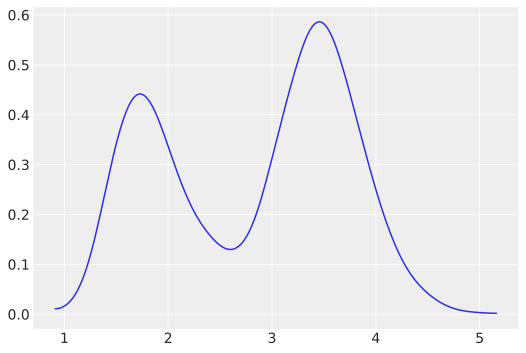

In [295]:
az.plot_kde(post_samples2['lambda'])

In [305]:
def model3(salaman=None, pctcover_std=None, log_forestage_ctr=None):
    a = numpyro.sample("a", dist.Normal(1.5, .25))
    bC = numpyro.sample("bC", dist.Normal(0, 0.5))
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a + bC * pctcover_std) + bF * log_forestage_ctr)
    numpyro.sample("salaman", dist.Poisson(lambda_), obs=salaman)

In [306]:
data = {col: d[col].values for col in ['pctcover_std', 'log_forestage_ctr', 'salaman']}
mcmc = MCMC(NUTS(model3), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(5), **data)
mcmc.print_summary()
post_samples3 = mcmc.get_samples()
logprob = log_likelihood(model3, post_samples3, **data)
az3 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:05<00:00, 294.39it/s, 1 steps of size 9.79e-02. acc. prob=0.85]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.71      0.15      0.70      0.48      0.96     23.84      1.00
        bC      0.46      0.24      0.47      0.10      0.83     26.12      1.00
        bF      0.43      0.08      0.43      0.30      0.57     27.22      1.01

Number of divergences: 843


<AxesSubplot:>

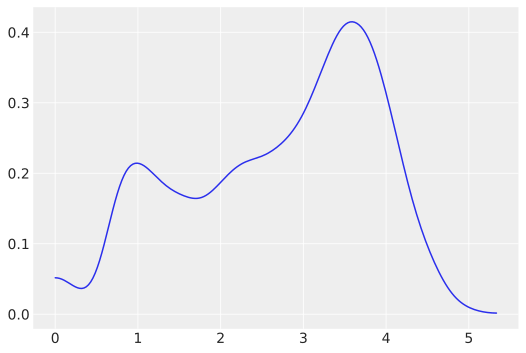

In [307]:
az.plot_kde(post_samples3['lambda'])

---

In [308]:
d["is_covered"] = (d["pctcover"] >= 67) * 1
display(d["is_covered"].value_counts())

d_cov = d[d.is_covered == 1]

1    28
0    19
Name: is_covered, dtype: int64

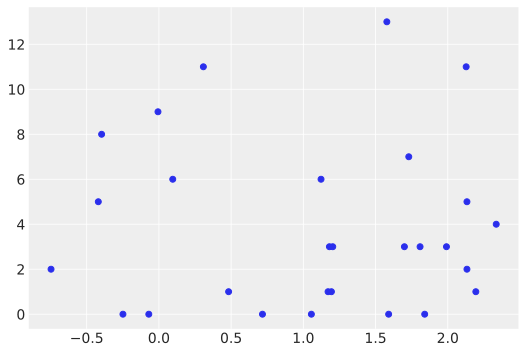

In [309]:
plt.scatter(d_cov.log_forestage_ctr.values, d_cov.salaman.values)

In [316]:
def model4(salaman=None, is_covered=None, log_forestage_ctr=None):
    a = numpyro.sample("a", dist.Normal(1.5, .25).expand([2]))
    bF = numpyro.sample("bF", dist.Normal(0, 0.5).expand([2]))
    
    lambda_ = numpyro.deterministic("lambda", jnp.exp(a[is_covered] + bF[is_covered] * log_forestage_ctr))
    
    numpyro.sample("salaman", dist.Poisson(lambda_), obs=salaman)

In [317]:
data = {col: d[col].values for col in ['is_covered', 'log_forestage_ctr', 'salaman']}
mcmc = MCMC(NUTS(model4), num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(54), **data)
mcmc.print_summary()
post_samples4 = mcmc.get_samples()
logprob = log_likelihood(model4, post_samples4, **data)
az4 = az.from_dict({}, log_likelihood={k: v[None] for k, v in logprob.items()})

sample: 100%|██████████| 1500/1500 [00:06<00:00, 215.66it/s, 7 steps of size 5.33e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.78      0.18      0.78      0.49      1.08    739.50      1.00
      a[1]      1.40      0.12      1.40      1.20      1.58    845.69      1.00
     bF[0]      0.71      0.19      0.69      0.39      1.00    620.07      1.00
     bF[1]     -0.04      0.09     -0.04     -0.20      0.09    790.54      1.00

Number of divergences: 0


<AxesSubplot:>

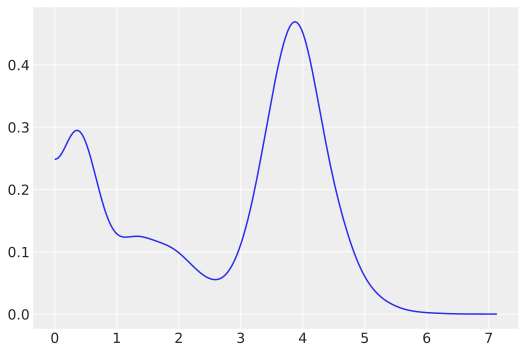

In [318]:
az.plot_kde(post_samples4['lambda'])

In [319]:
az.compare(
    {'az1': az1, 'az2': az2, 'az3': az3, 'az4': az4},
    ic='waic',
    scale='deviance'
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
az4,0,230.404,7.08735,0,0.7797,24.9611,0,True,deviance
az3,1,238.448,4.59894,8.04365,0.169852,24.7642,9.11923,True,deviance
az1,2,243.658,4.12793,13.254,0.0303076,25.2984,9.15535,True,deviance
az2,3,244.437,4.90389,14.0331,0.0201395,25.2261,9.23833,True,deviance


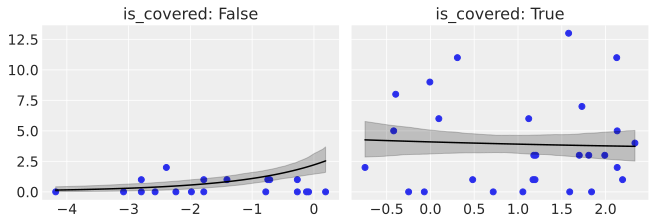

In [324]:
_, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)  # 3 plots in 1 row

for ax, is_covered in zip(axes, range(0, 2)):
    dd = d[d.is_covered == is_covered]
    x = jnp.linspace(dd.log_forestage_ctr.min(), dd.log_forestage_ctr.max(), 100)
    
    post_pred = Predictive(model4, post_samples4, return_sites=["lambda"]).get_samples(
        random.PRNGKey(38), log_forestage_ctr=x, is_covered=is_covered
    )["lambda"]
    lmu = jnp.mean(post_pred, axis=0)
    lPI = jnp.percentile(post_pred, q=(1.5, 97.5), axis=0)

    ax.scatter(dd.log_forestage_ctr.values, dd.salaman.values)
    ax.plot(x, lmu, 'k')
    ax.fill_between(x, lPI[0], lPI[1], color="k", alpha=0.2)
    ax.title.set_text(f"is_covered: {bool(is_covered)}")